In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Not used in this consolidated script's printouts
import seaborn as sns # Not used in this consolidated script's printouts

# --- STEP 1: Setup and Loading Initial Data from BigQuery ---
print("--- STEP 1: Setup and Loading Initial Data ---")
# This part should be run once to load your initial data.
# If running this as a whole new script, you need to execute your BigQuery loading logic first.
# Ensure df_companyaccounts, df_leads, etc., are loaded before proceeding.
from google.colab import auth
auth.authenticate_user()
# !pip install --quiet google-cloud-bigquery pandas openpyxl # Run this if not installed
from google.cloud import bigquery
PROJECT_ID = "lead-conversion-prediction" # Replace with your Project ID
DATASET = "lead_conversion_staging_tables" # Replace with your Dataset
client = bigquery.Client(project=PROJECT_ID)
def load_table(table_name):
    query = f"SELECT * FROM `{PROJECT_ID}.{DATASET}.{table_name}`"
    print(f"Loading table: {table_name}...")
    df = client.query(query).to_dataframe()
    print(f"Successfully loaded {table_name}. Shape: {df.shape}")
    return df

print("\nLoading initial tables ...")
df_companyaccounts = load_table("staging_companyaccounts")
df_leads = load_table("staging_leads")
df_contacts = load_table("staging_contacts")
df_projects = load_table("staging_projects")
df_meeting_notes = load_table("staging_meeting_notes")
print("\nInitial tables loaded.")

excel_file_path = 'Leads.xlsx' # Make sure this file is uploaded

if 'df_leads' in locals() and isinstance(df_leads, pd.DataFrame):
    original_leads_shape_before_excel = df_leads.shape
    try:

        df_new_lead_info = pd.read_excel(excel_file_path)
        original_df_leads_cols = set(df_leads.columns)
        df_leads = pd.merge(df_leads, df_new_lead_info, on='Id', how='left', suffixes=('', '_from_excel'))
        newly_added_cols = list(set(df_leads.columns) - original_df_leads_cols)
        if 'IsConverted' in df_leads.columns:
            print("Value counts for Leads converted to Clients in df_leads:")
            print(df_leads['IsConverted'].value_counts(dropna=False))
        else:
            print("WARNING: 'IsConverted' (from Excel) column not found in df_leads after merge.")
        if 'ConvertedAccountId' in df_leads.columns:
            print("\n'ConvertedAccountId' (from Excel) is now in df_leads.")
            print(f"Missing values in 'ConvertedAccountId' after merge: {df_leads['ConvertedAccountId'].isnull().sum()}")
        else:
            print("WARNING: 'ConvertedAccountId' (from Excel) column not found in df_leads after merge.")
    except FileNotFoundError:
        print(f"Error: The Excel file '{excel_file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred while loading or merging Excel file: {e}")
else:
    print("Error: df_leads DataFrame not found or not a DataFrame for Step 2. Please ensure initial load from BQ is done.")

--- STEP 1: Setup and Loading Initial Data ---

Loading initial tables ...
Loading table: staging_companyaccounts...
Successfully loaded staging_companyaccounts. Shape: (5631, 28)
Loading table: staging_leads...
Successfully loaded staging_leads. Shape: (47627, 20)
Loading table: staging_contacts...
Successfully loaded staging_contacts. Shape: (7374, 19)
Loading table: staging_projects...
Successfully loaded staging_projects. Shape: (4182, 48)
Loading table: staging_meeting_notes...
Successfully loaded staging_meeting_notes. Shape: (3181, 16)

Initial tables loaded.
Value counts for Leads converted to Clients in df_leads:
IsConverted
False    46177
True      1450
Name: count, dtype: int64

'ConvertedAccountId' (from Excel) is now in df_leads.
Missing values in 'ConvertedAccountId' after merge: 46220


In [16]:

# --- STEP 3: Convert String Representations of Missing Values to np.nan ---
print("\n\n--- STEP 3: Convert String Representations of Missing Values to np.nan ---")
dataframes_dict_cell3 = {
    "Company Accounts": df_companyaccounts if 'df_companyaccounts' in locals() else None,
    "Leads": df_leads if 'df_leads' in locals() else None,
    "Contacts": df_contacts if 'df_contacts' in locals() else None,
    "Projects": df_projects if 'df_projects' in locals() else None,
    "Meeting Notes": df_meeting_notes if 'df_meeting_notes' in locals() else None
}
missing_value_formats = ['nan', 'NaN', 'Nan', 'NAN', 'None', 'NONE', 'null', 'NULL', '', ' ', '--', 'N/A', 'n/a', 'NA', 'na']
for df_name, df_current in dataframes_dict_cell3.items():
    if df_current is None:
        print(f"\n--- Processing DataFrame: {df_name} ---")
        print(f"DataFrame '{df_name}' is not loaded. Skipping string NaN conversion.")
        continue
    print(f"\n--- Processing DataFrame: {df_name} ---")
    print(f"--- Step 3.1 for {df_name}: Converting string NaNs to actual np.nan values ---")
    for col in df_current.columns:
        if df_current[col].dtype == 'object':
            # Using .loc to ensure modification happens on the DataFrame directly
            df_current.loc[:, col] = df_current[col].replace(missing_value_formats, np.nan)
    print(f"String representations of missing values have been converted to np.nan for {df_name}.")
print("\nString NaN conversion step complete for all DataFrames.")

# --- STEP 4: Column Dropping/Selection ---
print("\n\n--- STEP 4: Column Dropping/Selection ---")
cols_to_drop_companyaccounts = ['About_the_Company__c', 'Areas_of_Interest__c', 'IPI_Remarks__c', 'IPI_WAR_Rating__c', 'Main_Products_Services__c', 'Other_Sources__c', 'ParentId', 'Other_Primary_Industry__c', 'Ready__c', 'Revenue__c', 'Tech_Seeker_Type__c', 'Year_of_Last_Engagement__c']
cols_to_drop_leads = ['Areas_of_Interest__c', 'Company_Classification__c', 'Company_Profile__c', 'Drop_Reason__c', 'Drop_Remarks__c', 'IPI_Remarks__c', 'Industry', 'Tech_Expert_Name__c', 'Tech_Need_Title__c', 'Tech_Offer_Title__c', 'Type_of_Enquiry__c', 'Type_of_Service__c']
cols_to_drop_contacts = ['Country__c', 'CventEvents__ContactStub__c', 'Cvent_Reference_ID__c', 'Cvent_Registration_Type__c', 'Source__c']
cols_to_drop_meeting_notes = ['Additional_Information__c', 'Background_Information__c', 'Meeting_Note_Migration_Ref_ID__c', 'Minutes_of_Meetings__c']

def drop_columns_and_summarize_detailed(df, df_name, cols_to_drop):
    if df is None: print(f"DataFrame '{df_name}' is not loaded. Skipping drop."); return None
    print(f"\n--- Processing DataFrame: {df_name} (Column Dropping) ---")
    print(f"Original shape: {df.shape}")
    print(f"Original columns: {df.columns.tolist()}")
    existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    if not existing_cols_to_drop:
        print(f"No specified columns from the drop list found in '{df_name}'.")
        df_modified = df.copy() # Ensure it's a copy if no changes
    else:
        df_modified = df.drop(columns=existing_cols_to_drop, errors='ignore')
        print(f"Dropped columns: {existing_cols_to_drop}")
    print(f"New shape: {df_modified.shape}")
    print(f"Remaining columns: {df_modified.columns.tolist()}")
    return df_modified

if 'df_companyaccounts' in locals(): df_companyaccounts = drop_columns_and_summarize_detailed(df_companyaccounts, "Company Accounts", cols_to_drop_companyaccounts)
if 'df_leads' in locals(): df_leads = drop_columns_and_summarize_detailed(df_leads, "Leads", cols_to_drop_leads)
if 'df_contacts' in locals(): df_contacts = drop_columns_and_summarize_detailed(df_contacts, "Contacts", cols_to_drop_contacts)

if 'df_projects' in locals() and df_projects is not None:
    print(f"\n--- Processing DataFrame: Projects (Column Selection) ---")
    print(f"Original shape of Projects: {df_projects.shape}")
    print(f"Original columns in Projects: {df_projects.columns.tolist()}")
    cols_to_keep_projects = []
    possible_lead_fk_cols = ['LeadId', 'Lead__c', 'Created_From_Lead__c', 'Lead']
    possible_conversion_cols = ['IsWon', 'is_converted', 'iswon']
    if 'Id' in df_projects.columns: cols_to_keep_projects.append('Id')
    lead_fk_found_col = None
    for col_name in possible_lead_fk_cols:
        if col_name in df_projects.columns:
            lead_fk_found_col = col_name
            break
    conversion_col_found = None
    for col_name in possible_conversion_cols:
        if col_name in df_projects.columns:
            conversion_col_found = col_name
            break
    if lead_fk_found_col: cols_to_keep_projects.append(lead_fk_found_col)
    if conversion_col_found: cols_to_keep_projects.append(conversion_col_found)

    cols_to_keep_projects = sorted(list(set(col for col in cols_to_keep_projects if col in df_projects.columns))) # ensure unique and exist

    if 'Id' in cols_to_keep_projects and lead_fk_found_col and conversion_col_found and \
       lead_fk_found_col in cols_to_keep_projects and conversion_col_found in cols_to_keep_projects:
        print(f"Identified columns to keep in Projects: {cols_to_keep_projects}")
        df_projects = df_projects[cols_to_keep_projects]
    else:
        print(f"WARNING: Could not robustly identify all essential columns in df_projects. Kept: {cols_to_keep_projects}. Review manually.")
        # Fallback: if essential columns are not found, we keep the current df_projects or user can decide to drop all but 'Id'
        # For now, it means if conditions not met, df_projects is not filtered by specific keep list here, relies on existing state.
    print(f"New shape of Projects: {df_projects.shape}")
    print(f"Remaining columns in Projects: {df_projects.columns.tolist()}")
else:
    print("df_projects not available for column keeping.")
if 'df_meeting_notes' in locals(): df_meeting_notes = drop_columns_and_summarize_detailed(df_meeting_notes, "Meeting Notes", cols_to_drop_meeting_notes)
print("\nColumn dropping/selection step complete.")




--- STEP 3: Convert String Representations of Missing Values to np.nan ---

--- Processing DataFrame: Company Accounts ---
--- Step 3.1 for Company Accounts: Converting string NaNs to actual np.nan values ---
String representations of missing values have been converted to np.nan for Company Accounts.

--- Processing DataFrame: Leads ---
--- Step 3.1 for Leads: Converting string NaNs to actual np.nan values ---


/tmp/ipython-input-16-4248627436.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_current.loc[:, col] = df_current[col].replace(missing_value_formats, np.nan)


String representations of missing values have been converted to np.nan for Leads.

--- Processing DataFrame: Contacts ---
--- Step 3.1 for Contacts: Converting string NaNs to actual np.nan values ---
String representations of missing values have been converted to np.nan for Contacts.

--- Processing DataFrame: Projects ---
--- Step 3.1 for Projects: Converting string NaNs to actual np.nan values ---
String representations of missing values have been converted to np.nan for Projects.

--- Processing DataFrame: Meeting Notes ---
--- Step 3.1 for Meeting Notes: Converting string NaNs to actual np.nan values ---
String representations of missing values have been converted to np.nan for Meeting Notes.

String NaN conversion step complete for all DataFrames.


--- STEP 4: Column Dropping/Selection ---

--- Processing DataFrame: Company Accounts (Column Dropping) ---
Original shape: (5631, 28)
Original columns: ['Id', 'About_the_Company__c', 'Areas_of_Interest__c', 'Name', 'Company_Profile__c

In [17]:

# --- STEP 5: Missing Value Analysis (Post Column Dropping) ---
print("\n\n--- STEP 5: Missing Value Analysis (Post Column Dropping) ---")
dataframes_dict_cell5 = {
    "Company Accounts": df_companyaccounts if 'df_companyaccounts' in locals() else None,
    "Leads": df_leads if 'df_leads' in locals() else None,
    "Contacts": df_contacts if 'df_contacts' in locals() else None,
    "Projects": df_projects if 'df_projects' in locals() else None,
    "Meeting Notes": df_meeting_notes if 'df_meeting_notes' in locals() else None
}
for df_name, df_current in dataframes_dict_cell5.items():
    if df_current is None:
        print(f"\n--- Analyzing DataFrame: {df_name} ---")
        print(f"DataFrame '{df_name}' is not loaded. Skipping missing value analysis.")
        continue
    print(f"\n--- Analyzing DataFrame: {df_name} (Shape: {df_current.shape}) ---")
    missing_values = df_current.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if not missing_cols.empty:
        print("Missing values per column (count):")
        print(missing_cols)
        missing_percentage = (missing_cols / len(df_current)) * 100
        print("\nMissing values per column (percentage):")
        print(missing_percentage)
    else:
        print("No missing values found in the remaining columns.")
print("\nMissing value analysis complete.")

# --- STEP 6: Row Deletion for False Company Names ---
print("\n\n--- STEP 6: Row Deletion for False Company Names ---")
false_company_names_to_delete = ["83", "99", "111234", "-", "[Company]"]
if 'df_leads' in locals() and df_leads is not None:
    print(f"\n--- Processing DataFrame: Leads (False Company Name Removal) ---")
    leads_company_col = 'Company'
    if leads_company_col in df_leads.columns:
        original_lead_count = len(df_leads)
        print(f"Original row count in df_leads: {original_lead_count}")
        df_leads[leads_company_col] = df_leads[leads_company_col].astype(str)
        df_leads = df_leads[~df_leads[leads_company_col].isin(false_company_names_to_delete)]
        rows_removed = original_lead_count - len(df_leads)
        print(f"Removed {rows_removed} rows from df_leads with false company names.")
        print(f"New shape of df_leads: {df_leads.shape}")
    else: print(f"Column '{leads_company_col}' not found in df_leads.")
else: print("df_leads not available for false company name removal.")

if 'df_companyaccounts' in locals() and df_companyaccounts is not None:
    print(f"\n--- Processing DataFrame: Company Accounts (False Name Removal) ---")
    accounts_name_col = 'Name'
    if accounts_name_col in df_companyaccounts.columns:
        original_account_count = len(df_companyaccounts)
        print(f"Original row count in df_companyaccounts: {original_account_count}")
        df_companyaccounts[accounts_name_col] = df_companyaccounts[accounts_name_col].astype(str)
        df_companyaccounts = df_companyaccounts[~df_companyaccounts[accounts_name_col].isin(false_company_names_to_delete)]
        rows_removed_accounts = original_account_count - len(df_companyaccounts)
        print(f"Removed {rows_removed_accounts} rows from df_companyaccounts with false names.")
        print(f"New shape of df_companyaccounts: {df_companyaccounts.shape}")
    else: print(f"Column '{accounts_name_col}' not found in df_companyaccounts.")
else: print("df_companyaccounts not available for false name removal.")
print("\nRow deletion step for false company names complete.")

# --- STEP 7: Merging Account Information into Leads DataFrame ---
print("\n\n--- STEP 7: Merging Account Information into Leads DataFrame ---")
if ('df_leads' in locals() and df_leads is not None) and \
   ('df_companyaccounts' in locals() and df_companyaccounts is not None):
    print(f"\n--- Processing DataFrame: Leads (Account Info Augmentation) ---")
    accounts_pk_col = 'Id'
    accounts_name_col = 'Name' # In CompanyAccounts
    leads_company_name_col = 'Company' # In Leads
    possible_leads_fk_to_accounts = ['ConvertedAccountId', 'AccountId', 'Account_Id'] # Prioritized FKs
    actual_leads_fk_col = None
    for col_name in possible_leads_fk_to_accounts:
        if col_name in df_leads.columns: actual_leads_fk_col = col_name; break

    cols_from_accounts_to_merge = ['Id', 'Industry', 'Primary_Industry__c', 'Country__c', 'Company_Profile__c', 'Year_of_First_Engagement__c', 'AccountSource']
    cols_from_accounts_to_merge = [col for col in cols_from_accounts_to_merge if col in df_companyaccounts.columns] # Ensure columns exist
    df_accounts_subset = df_companyaccounts[cols_from_accounts_to_merge].copy()
    original_leads_shape_before_account_merge = df_leads.shape

    print(f"\n--- Step 7.1: ID-based Merge ---")
    if actual_leads_fk_col and accounts_pk_col in df_accounts_subset.columns:
        print(f"Found Account ID foreign key in df_leads: '{actual_leads_fk_col}'. Using it for ID-based merge with df_companyaccounts['{accounts_pk_col}'].")
        df_leads = pd.merge(df_leads, df_accounts_subset, left_on=actual_leads_fk_col, right_on=accounts_pk_col, how='left', suffixes=('', '_FromAccount'))
        print(f"ID-based merge complete. df_leads shape changed from {original_leads_shape_before_account_merge} to {df_leads.shape}")
    else:
        print(f"Skipped ID-based merge. Conditions not met (Actual FK in Leads: '{actual_leads_fk_col}', PK in Accounts subset: '{accounts_pk_col in df_accounts_subset.columns}').")

    print(f"\n--- Step 7.2: Name-based Join/Fill (for remaining account info) ---")
    if leads_company_name_col in df_leads.columns and accounts_name_col in df_companyaccounts.columns: # df_companyaccounts here is the original one
        print(f"Attempting name-based join/fill using df_leads['{leads_company_name_col}'] and df_companyaccounts['{accounts_name_col}'].")
        # Ensure clean name columns are on the original df_companyaccounts for the map
        if 'Clean_Account_Name' not in df_companyaccounts.columns:
             df_companyaccounts.loc[:, 'Clean_Account_Name'] = df_companyaccounts[accounts_name_col].astype(str).str.lower().str.strip()

        df_leads.loc[:, 'Clean_Lead_Company_Name'] = df_leads[leads_company_name_col].astype(str).str.lower().str.strip()

        # Create mapping from the original df_companyaccounts to avoid issues with subset
        df_accounts_for_map = df_companyaccounts.drop_duplicates(subset=['Clean_Account_Name'], keep='first')

        for acc_col in cols_from_accounts_to_merge: # These are original names from df_companyaccounts
            if acc_col == accounts_pk_col: continue # Skip the ID itself if it was already merged
            target_col_in_leads = acc_col + '_FromAccount' # This is the name of the column in df_leads AFTER ID merge
            if target_col_in_leads not in df_leads.columns: # If ID merge didn't create it (e.g. FK was not ConvertedAccountId)
                df_leads[target_col_in_leads] = np.nan # Create the column

            if acc_col in df_accounts_for_map.columns: # acc_col is the original name in df_companyaccounts
                name_to_feature_map = df_accounts_for_map.set_index('Clean_Account_Name')[acc_col]
                condition_to_fill = df_leads[target_col_in_leads].isnull()
                num_to_fill = condition_to_fill.sum()
                if num_to_fill > 0:
                    print(f"  For column '{target_col_in_leads}', {num_to_fill} values are null. Attempting to fill using name map for '{acc_col}'.")
                    values_to_map = df_leads.loc[condition_to_fill, 'Clean_Lead_Company_Name'].map(name_to_feature_map)
                    df_leads.loc[condition_to_fill, target_col_in_leads] = df_leads.loc[condition_to_fill, target_col_in_leads].fillna(values_to_map)
                    filled_count = num_to_fill - df_leads[target_col_in_leads].isnull().sum()
                    print(f"    Filled {filled_count} values in '{target_col_in_leads}' using name-based map.")
        if 'Clean_Lead_Company_Name' in df_leads.columns: df_leads.drop(columns=['Clean_Lead_Company_Name'], inplace=True)
    else:
        print("Skipped name-based join. Company name columns not found in both DataFrames.")

    # Clean up redundant ID column from merge if it has suffix _FromAccount and is different from the actual_leads_fk_col
    id_col_from_account_merge = accounts_pk_col + '_FromAccount'
    if id_col_from_account_merge in df_leads.columns and actual_leads_fk_col != id_col_from_account_merge :
        df_leads = df_leads.drop(columns=[id_col_from_account_merge])
        print(f"Dropped redundant ID column '{id_col_from_account_merge}' from df_leads.")
    print(f"Account info merge/augmentation attempt complete. Final df_leads shape: {df_leads.shape}")
    print(f"Columns in df_leads after account merge: {df_leads.columns.tolist()}")
else:
    print("Error: df_leads or df_companyaccounts not found for Account Info Merge step.")
print("\nAccount information merging step complete.")



--- STEP 5: Missing Value Analysis (Post Column Dropping) ---

--- Analyzing DataFrame: Company Accounts (Shape: (5631, 16)) ---
Missing values per column (count):
Name                              1
Company_Profile__c             1838
Country__c                      117
Nature_of_Business__c          2717
Industry                         62
Primary_Industry__c            1620
AccountSource                  1894
Lead_Source__c                 2269
Year_of_First_Engagement__c      14
dtype: int64

Missing values per column (percentage):
Name                            0.017759
Company_Profile__c             32.640739
Country__c                      2.077784
Nature_of_Business__c          48.250755
Industry                        1.101048
Primary_Industry__c            28.769313
AccountSource                  33.635234
Lead_Source__c                 40.294797
Year_of_First_Engagement__c     0.248624
dtype: float64

--- Analyzing DataFrame: Leads (Shape: (47627, 13)) ---
Missing values 

/tmp/ipython-input-17-1560489201.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan 'Healthcare']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_leads.loc[condition_to_fill, target_col_in_leads] = df_leads.loc[condition_to_fill, target_col_in_leads].fillna(values_to_map)
/tmp/ipython-input-17-1560489201.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan 'Healthcare']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_leads.loc[condition_to_fill, target_col_in_leads] = df_leads.loc[condition_to_fill, target_col_in_leads].fillna(values_to_map)
/tmp/ipython-input-17-1560489201.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a f

In [18]:


# --- STEP 8: Data Imputation ---
print("\n\n--- STEP 8: Data Imputation ---")
imputation_details = []

# Impute df_leads
if 'df_leads' in locals() and df_leads is not None:
    print(f"\n--- Imputing DataFrame: Leads ---")
    cols_to_impute_leads = {'Address_country': 'Unknown_Country', 'Company': 'Unknown_Company', 'LeadSource': 'Unknown_Source'}
    for col, fill_val in cols_to_impute_leads.items():
        if col in df_leads.columns and df_leads[col].isnull().any():
            missing_before = df_leads[col].isnull().sum()
            df_leads[col] = df_leads[col].fillna(fill_val)
            imputation_details.append(f"Leads: Imputed '{col}' ({missing_before} missing) with '{fill_val}'. Now {df_leads[col].isnull().sum()} missing.")
        elif col in df_leads.columns:
            imputation_details.append(f"Leads: No missing values in '{col}'.")
        else:
            imputation_details.append(f"Leads: Column '{col}' not found for imputation.")
    print(f"Missing values in df_leads after imputation pass (excluding specific FKs like ConvertedAccountId):")
    leads_missing_post_impute = df_leads.drop(columns=[col for col in ['ConvertedAccountId', 'ConvertedContactId', 'ConvertedDate', 'ConvertedOpportunityId'] if col in df_leads.columns], errors='ignore').isnull().sum()
    print(leads_missing_post_impute[leads_missing_post_impute > 0])

else: print("df_leads not found for imputation.")

# Impute df_companyaccounts
if 'df_companyaccounts' in locals() and df_companyaccounts is not None:
    print(f"\n--- Imputing DataFrame: Company Accounts ---")
    cols_to_impute_cat_accounts = {'Name': 'Unknown_Account_Name', 'Company_Profile__c': 'Unknown_Profile', 'Country__c': 'Unknown_Country', 'Nature_of_Business__c': 'Unknown_Nature', 'Industry': 'Unknown_Industry', 'Primary_Industry__c': 'Unknown_Primary_Industry', 'AccountSource': 'Unknown_Source', 'Lead_Source__c': 'Unknown_Source'}
    for col, fill_val in cols_to_impute_cat_accounts.items():
        if col in df_companyaccounts.columns and df_companyaccounts[col].isnull().any():
            missing_before = df_companyaccounts[col].isnull().sum()
            df_companyaccounts[col] = df_companyaccounts[col].fillna(fill_val)
            imputation_details.append(f"Company Accounts: Imputed '{col}' ({missing_before} missing) with '{fill_val}'. Now {df_companyaccounts[col].isnull().sum()} missing.")
        elif col in df_companyaccounts.columns:
            imputation_details.append(f"Company Accounts: No missing values in '{col}'.")
        else:
             imputation_details.append(f"Company Accounts: Column '{col}' not found for imputation.")
    # Numerical imputation for Year_of_First_Engagement__c
    year_col = 'Year_of_First_Engagement__c'
    if year_col in df_companyaccounts.columns and df_companyaccounts[year_col].isnull().any():
        missing_before = df_companyaccounts[year_col].isnull().sum()
        df_companyaccounts[year_col] = pd.to_numeric(df_companyaccounts[year_col], errors='coerce')
        median_val = df_companyaccounts[year_col].median()
        df_companyaccounts[year_col] = df_companyaccounts[year_col].fillna(median_val)
        imputation_details.append(f"Company Accounts: Imputed '{year_col}' ({missing_before} missing) with median '{median_val}'. Now {df_companyaccounts[year_col].isnull().sum()} missing.")
    elif year_col in df_companyaccounts.columns:
        imputation_details.append(f"Company Accounts: No missing values in '{year_col}'.")

    print(f"Missing values in df_companyaccounts after imputation pass:")
    ca_missing_post_impute = df_companyaccounts.isnull().sum()
    print(ca_missing_post_impute[ca_missing_post_impute > 0])
else: print("df_companyaccounts not found for imputation.")

# Impute df_contacts
if 'df_contacts' in locals() and df_contacts is not None:
    print(f"\n--- Imputing DataFrame: Contacts ---")
    cols_to_impute_contacts = {'Areas_of_Interest__c': 'Unknown_Interest', 'AccountId': 'Unknown_Account_FK', 'LeadSource': 'Unknown_Source'}
    for col, fill_val in cols_to_impute_contacts.items():
        if col in df_contacts.columns and df_contacts[col].isnull().any():
            missing_before = df_contacts[col].isnull().sum()
            df_contacts[col] = df_contacts[col].fillna(fill_val)
            imputation_details.append(f"Contacts: Imputed '{col}' ({missing_before} missing) with '{fill_val}'. Now {df_contacts[col].isnull().sum()} missing.")
        elif col in df_contacts.columns:
            imputation_details.append(f"Contacts: No missing values in '{col}'.")
        else:
            imputation_details.append(f"Contacts: Column '{col}' not found for imputation.")
    print(f"Missing values in df_contacts after imputation pass:")
    contacts_missing_post_impute = df_contacts.isnull().sum()
    print(contacts_missing_post_impute[contacts_missing_post_impute > 0])
else: print("df_contacts not found for imputation.")

# Impute df_meeting_notes
if 'df_meeting_notes' in locals() and df_meeting_notes is not None:
    print(f"\n--- Imputing DataFrame: Meeting Notes ---")
    cols_to_impute_meeting = {'Company_Country__c': 'Unknown_Country', 'Company_Needs__c': 'Unknown_Needs', 'Follow_Up_Action__c': 'No_Action_Specified', 'Lead__c': 'Unknown_Lead_FK', 'Organisation__c': 'Unknown_Organisation_FK', 'Potential__c': 'Unknown_Potential', 'RecordTypeId': 'Unknown_RecordType', 'Source__c': 'Unknown_Source'}
    for col, fill_val in cols_to_impute_meeting.items():
        if col in df_meeting_notes.columns and df_meeting_notes[col].isnull().any():
            missing_before = df_meeting_notes[col].isnull().sum()
            df_meeting_notes[col] = df_meeting_notes[col].fillna(fill_val)
            imputation_details.append(f"Meeting Notes: Imputed '{col}' ({missing_before} missing) with '{fill_val}'. Now {df_meeting_notes[col].isnull().sum()} missing.")
        elif col in df_meeting_notes.columns:
            imputation_details.append(f"Meeting Notes: No missing values in '{col}'.")
        else:
            imputation_details.append(f"Meeting Notes: Column '{col}' not found for imputation.")
    if 'Lead__c' in df_meeting_notes.columns and (df_meeting_notes['Lead__c'] == 'Unknown_Lead_FK').sum() / len(df_meeting_notes) > 0.9:
         imputation_details.append("WARNING: 'Lead__c' in Meeting Notes is overwhelmingly 'Unknown_Lead_FK' after imputation.")
         print("WARNING: 'Lead__c' in Meeting Notes is still overwhelmingly 'Unknown_Lead_FK'.")
    print(f"Missing values in df_meeting_notes after imputation pass:")
    mn_missing_post_impute = df_meeting_notes.isnull().sum()
    print(mn_missing_post_impute[mn_missing_post_impute > 0])

else: print("df_meeting_notes not found for imputation.")

print("\nSummary of Imputation Actions:")
for detail in imputation_details:
    print(f"  - {detail}")
print("\nData imputation step complete.")




--- STEP 8: Data Imputation ---

--- Imputing DataFrame: Leads ---
Missing values in df_leads after imputation pass (excluding specific FKs like ConvertedAccountId):
Industry                                   31280
Primary_Industry__c                        31978
Country__c                                 31202
Company_Profile__c                         31639
Year_of_First_Engagement__c                31208
AccountSource                              31265
Industry_FromAccount                       16376
Primary_Industry__c_FromAccount            27447
Country__c_FromAccount                     16267
Company_Profile__c_FromAccount             18275
Year_of_First_Engagement__c_FromAccount    16262
AccountSource_FromAccount                  17637
dtype: int64

--- Imputing DataFrame: Company Accounts ---
Missing values in df_companyaccounts after imputation pass:
Series([], dtype: int64)

--- Imputing DataFrame: Contacts ---
Missing values in df_contacts after imputation pass:
Series([]

In [19]:

# --- STEP 9: Feature Engineering, Target Creation, Encoding (df_master) ---
print("\n\n--- STEP 9: Feature Engineering, Target Creation, Encoding (df_master) ---")
projects_lead_fk_col = None
projects_target_col = None
target_col_in_master = None

if 'df_leads' in locals() and df_leads is not None:
    print(f"\n--- Step 9.1: Date Feature Engineering (df_leads) ---")
    if 'CreatedDate' in df_leads.columns:
        if not pd.api.types.is_datetime64_any_dtype(df_leads['CreatedDate']):
            df_leads['CreatedDate'] = pd.to_datetime(df_leads['CreatedDate'], errors='coerce')
        if 'Lead_Created_Year' not in df_leads.columns:
            df_leads['Lead_Created_Year'] = df_leads['CreatedDate'].dt.year
            df_leads['Lead_Created_Month'] = df_leads['CreatedDate'].dt.month
            df_leads['Lead_Created_DayOfWeek'] = df_leads['CreatedDate'].dt.dayofweek
            print("Added Lead_Created_Year, Lead_Created_Month, Lead_Created_DayOfWeek to df_leads.")
        else:
            print("Date features (Year, Month, DayOfWeek) already exist in df_leads.")
    else:
        print("Column 'CreatedDate' not found in df_leads. Skipping date feature engineering.")

    print(f"\n--- Step 9.2: Account Tenure Feature (df_leads) ---")
    account_tenure_col_name = 'Year_of_First_Engagement__c_FromAccount'
    if account_tenure_col_name in df_leads.columns and 'Lead_Created_Year' in df_leads.columns:
        df_leads[account_tenure_col_name] = pd.to_numeric(df_leads[account_tenure_col_name], errors='coerce')
        df_leads['Account_Tenure_At_Lead_Creation'] = df_leads['Lead_Created_Year'] - df_leads[account_tenure_col_name]
        df_leads.loc[df_leads['Account_Tenure_At_Lead_Creation'] < 0, 'Account_Tenure_At_Lead_Creation'] = 0 # Tenure cannot be negative
        # Impute NaNs that might arise if 'Year_of_First_Engagement__c_FromAccount' or 'Lead_Created_Year' had NaNs
        if df_leads['Account_Tenure_At_Lead_Creation'].isnull().any():
            median_tenure = df_leads['Account_Tenure_At_Lead_Creation'].median()
            df_leads['Account_Tenure_At_Lead_Creation'].fillna(median_tenure, inplace=True)
            print(f"Imputed NaNs in 'Account_Tenure_At_Lead_Creation' with median value: {median_tenure}")
        print("Added 'Account_Tenure_At_Lead_Creation' to df_leads.")
    else:
        print(f"Could not create 'Account_Tenure_At_Lead_Creation': '{account_tenure_col_name}' or 'Lead_Created_Year' missing or other issue.")

    print(f"\n--- Step 9.3: Creating df_master from df_leads ---")
    df_master = df_leads.copy()
    print(f"Created df_master from df_leads. Shape: {df_master.shape}")
    print(f"Columns in df_master: {df_master.columns.tolist()}")

    print(f"\n--- Step 9.4: Target Variable Creation ('is_converted') ---")
    if 'IsConverted' in df_master.columns: # This comes from the Excel file
        print("Creating 'is_converted' target variable directly from 'IsConverted' (from Excel merge).")
        # Ensure 'IsConverted' is boolean before converting to int; fill NaNs from merge as False
        df_master['is_converted'] = df_master['IsConverted'].fillna(False).astype(bool).astype(int)
        print("Target variable 'is_converted' created from 'IsConverted' (Excel).")
    elif 'df_projects' in locals() and df_projects is not None: # Fallback to df_projects if 'IsConverted' not in df_master
        print("WARNING: 'IsConverted' (from Excel) not in df_master. Attempting to use df_projects to create target.")
        # Identify Lead FK in projects (e.g., 'Created_From_Lead__c' or 'LeadId')
        possible_lead_fk_cols_proj = ['Created_From_Lead__c', 'LeadId', 'Lead__c'] # from earlier definition
        for col in possible_lead_fk_cols_proj:
            if col in df_projects.columns: projects_lead_fk_col = col; break
        # Identify target col in projects (e.g., 'IsWon')
        projects_target_col = 'IsWon' # from earlier definition

        if projects_lead_fk_col and projects_target_col in df_projects.columns and 'Id' in df_master.columns: # 'Id' is Lead Id in df_master
            print(f"Attempting to merge df_projects into df_master using: df_master['Id'] (LeadId) and df_projects['{projects_lead_fk_col}']")
            df_projects_subset = df_projects[[projects_lead_fk_col, projects_target_col]].copy()
            # Ensure no duplicate Lead FKs in df_projects_subset if a lead could link to multiple projects
            df_projects_subset.drop_duplicates(subset=[projects_lead_fk_col], keep='first', inplace=True)

            df_master = pd.merge(df_master, df_projects_subset, left_on='Id', right_on=projects_lead_fk_col, how='left', suffixes=('', '_ProjectTarget'))
            target_col_in_master_suffixed = projects_target_col + '_ProjectTarget'

            if target_col_in_master_suffixed in df_master.columns:
                df_master['is_converted'] = df_master[target_col_in_master_suffixed].fillna(False).astype(bool).astype(int)
                print(f"Created 'is_converted' from df_projects column '{target_col_in_master_suffixed}'.")
                # Clean up merged columns from projects if they are not the final target
                cols_to_drop_from_project_merge = [projects_lead_fk_col, target_col_in_master_suffixed]
                if projects_lead_fk_col == 'Id': # if the FK from project was also named 'Id'
                    cols_to_drop_from_project_merge.append(projects_lead_fk_col + '_ProjectTarget') # if 'Id_ProjectTarget' was created
                df_master.drop(columns=[col for col in cols_to_drop_from_project_merge if col in df_master.columns and col != 'is_converted'], errors='ignore', inplace=True)

            else:
                print(f"CRITICAL WARNING: Merged target column '{target_col_in_master_suffixed}' not found. Defaulting 'is_converted' to 0.")
                df_master['is_converted'] = 0
        else:
            print(f"CRITICAL WARNING: Key columns missing for df_projects merge (Lead FK: {projects_lead_fk_col}, Target: {projects_target_col}, Lead ID in master: {'Id' in df_master.columns}). Defaulting 'is_converted' to 0.")
            df_master['is_converted'] = 0
    else:
        print("CRITICAL WARNING: No source for target variable ('IsConverted' from Excel or df_projects). 'is_converted' defaulted to 0.")
        df_master['is_converted'] = 0

    print("\nValue counts for 'is_converted' in df_master:")
    print(df_master['is_converted'].value_counts(dropna=False))

    print(f"\n--- Step 9.5: Encoding Categorical Features (df_master) ---")
    categorical_features_to_encode = [
        # 'Industry', # This was from original leads, now we use Industry_FromAccount
        'Address_country', 'LeadSource', 'Status', 'IAP__c', 'Lead_RT_Name__c', # From df_leads
        'Industry_FromAccount', 'Primary_Industry__c_FromAccount', 'Country__c_FromAccount', # From df_companyaccounts via merge
        'Company_Profile__c_FromAccount', 'AccountSource_FromAccount' # From df_companyaccounts via merge
    ]
    # Add the original 'Industry' from leads if it was kept and imputed differently
    if 'Industry' in df_master.columns and 'Industry_FromAccount' in df_master.columns:
         # If 'Industry' (original from leads) is still present and different from 'Industry_FromAccount', decide which to use or if both.
         # For this script, assuming 'Industry_FromAccount' is preferred if available.
         # If 'Industry' (from leads) is the one intended for encoding (e.g. after Gemini imputation):
         # categorical_features_to_encode.append('Industry')
         pass # Current list already prioritizes _FromAccount columns
    elif 'Industry' in df_master.columns and 'Industry_FromAccount' not in df_master.columns:
        categorical_features_to_encode.append('Industry')


    existing_categorical_features = [col for col in categorical_features_to_encode if col in df_master.columns]
    print(f"Categorical features identified for one-hot encoding: {existing_categorical_features}")

    if 'Status' in existing_categorical_features:
        print("\n--- Inspecting 'Status' column before encoding for data leakage ---")
        status_unique_values = df_master['Status'].unique()
        print(f"Unique values in df_master['Status']: {status_unique_values}")
        problematic_status_values = ['Converted', 'Closed Won', 'Closed Lost', 'Disqualified - Final', 'Dropped - Final'] # Adjust as needed
        leakage_found = any(status_val in status_unique_values for status_val in problematic_status_values)
        if leakage_found:
            print(f"WARNING: 'Status' column contains values ({[s for s in problematic_status_values if s in status_unique_values]}) that might cause data leakage if one-hot encoded directly.")
            print("Removing 'Status' from the list of features to be one-hot encoded.")
            existing_categorical_features.remove('Status')
        else:
            print("'Status' column does not seem to contain obvious post-conversion leakage terms based on the check list.")

    if existing_categorical_features:
        # Convert boolean IAP__c to string before get_dummies if it's boolean
        if 'IAP__c' in existing_categorical_features and pd.api.types.is_bool_dtype(df_master['IAP__c']):
            print("Converting boolean 'IAP__c' to string type for one-hot encoding.")
            df_master['IAP__c'] = df_master['IAP__c'].astype(str)

        original_shape = df_master.shape
        print(f"Shape of df_master before one-hot encoding: {original_shape}")
        df_master = pd.get_dummies(df_master, columns=existing_categorical_features, dummy_na=False, drop_first=False) # drop_first=False is often safer for analysis
        print(f"Shape of df_master after one-hot encoding: {df_master.shape}")
        print(f"Number of columns added by one-hot encoding: {df_master.shape[1] - original_shape[1]}")
    else:
        print("No specified categorical features found or remaining in df_master for encoding.")
else:
    print("df_leads not available. Cannot proceed with final feature engineering, target creation, and encoding.")

print("\n\n--- All Processing Steps From Notebook Applied with Detailed Prints ---")
print("Review df_master, especially the 'is_converted' column and its value counts.")
print("The original 'Industry' column in df_master (from leads) can now be imputed using Gemini API if desired, before model training, if it was not handled by account merge.")
print("Next main steps: Further feature selection/scaling, data splitting, and model training.")

# Optional: Save the processed df_master
# df_master.to_csv("df_master_processed_detailed_prints.csv", index=False)
# print("\nSaved df_master_processed_detailed_prints.csv")



--- STEP 9: Feature Engineering, Target Creation, Encoding (df_master) ---

--- Step 9.1: Date Feature Engineering (df_leads) ---
Added Lead_Created_Year, Lead_Created_Month, Lead_Created_DayOfWeek to df_leads.

--- Step 9.2: Account Tenure Feature (df_leads) ---
Imputed NaNs in 'Account_Tenure_At_Lead_Creation' with median value: 3.0
Added 'Account_Tenure_At_Lead_Creation' to df_leads.

--- Step 9.3: Creating df_master from df_leads ---
Created df_master from df_leads. Shape: (32608, 29)
Columns in df_master: ['Id', 'Address_country', 'Company', 'CreatedDate', 'IAP__c', 'Lead_RT_Name__c', 'LeadSource', 'Status', 'IsConverted', 'ConvertedAccountId', 'ConvertedContactId', 'ConvertedDate', 'ConvertedOpportunityId', 'Industry', 'Primary_Industry__c', 'Country__c', 'Company_Profile__c', 'Year_of_First_Engagement__c', 'AccountSource', 'Industry_FromAccount', 'Primary_Industry__c_FromAccount', 'Country__c_FromAccount', 'Company_Profile__c_FromAccount', 'Year_of_First_Engagement__c_FromAcco

/tmp/ipython-input-19-3197617425.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_leads['Account_Tenure_At_Lead_Creation'].fillna(median_tenure, inplace=True)


In [20]:
# --- STEP 10: Prepare Data for Modeling (Splitting into Features and Target) ---
from sklearn.model_selection import train_test_split # <--- ADD THIS IMPORT HERE

print("\n\n--- STEP 10: Prepare Data for Modeling ---")

if 'df_master' in locals() and isinstance(df_master, pd.DataFrame):
    print(f"Original df_master shape: {df_master.shape}")
    print(f"Columns in df_master before selecting X and y: {df_master.columns.tolist()}")

    # Define the target variable
    target_variable = 'is_converted'
    if target_variable not in df_master.columns:
        raise ValueError(f"Target variable '{target_variable}' not found in df_master columns!")
    y = df_master[target_variable]

    # Define features to drop before creating X (features matrix)
    # These typically include IDs, the original target if different, and any raw date columns if date features were engineered
    # Also drop the original IsConverted if it's still there and different from is_converted
    # ConvertedAccountId, ConvertedContactId, ConvertedDate, ConvertedOpportunityId are related to the conversion outcome itself
    # or are high cardinality IDs not useful for direct modeling after merge.
    columns_to_drop_for_X = [
        'Id', 'CreatedDate', 'IsConverted', # Original IsConverted from Excel, target is 'is_converted'
        'ConvertedAccountId', 'ConvertedContactId', 'ConvertedDate_from_excel', # if _from_excel suffix exists for ConvertedDate
        'ConvertedOpportunityId',
        target_variable # Ensure target is not in features
    ]
    # Also, 'Status' was already handled for leakage (removed from OHE list),
    # if it was not dropped from df_master entirely, it should be dropped here if it's still an object type or a raw column.
    # However, your previous cell (execution_count: 5) OHEs everything except Status, and then the modeling cell (execution_count: 7)
    # later drops object columns. Let's be explicit here for columns not intended as features.

    # Identify actual columns to drop that exist in df_master
    actual_columns_to_drop = [col for col in columns_to_drop_for_X if col in df_master.columns]
    # Check if 'ConvertedDate' from the original Leads table (not from excel) is also present
    # df_master was created from df_leads, so df_leads['CreatedDate'] became df_master['CreatedDate']
    if 'ConvertedDate' in df_master.columns and 'ConvertedDate' not in actual_columns_to_drop: # This is likely the datetime object from original leads.
         actual_columns_to_drop.append('ConvertedDate')


    print(f"Columns to be dropped to create X: {list(set(actual_columns_to_drop))}")
    X = df_master.drop(columns=list(set(actual_columns_to_drop)), errors='ignore')
    print(f"Shape of X (features): {X.shape}")
    print(f"Shape of y (target): {y.shape}")

    # --- STEP 11: Splitting Data into Training and Testing sets ---
    print("\n--- STEP 11: Splitting Data into Training and Testing sets ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print("Data splitting complete. X_train, X_test, y_train, y_test are now defined.")

else:
    print("Error: df_master is not defined or not a DataFrame. Cannot proceed with splitting.")



--- STEP 10: Prepare Data for Modeling ---
Original df_master shape: (32608, 288)
Columns in df_master before selecting X and y: ['Id', 'Company', 'CreatedDate', 'Status', 'IsConverted', 'ConvertedAccountId', 'ConvertedContactId', 'ConvertedDate', 'ConvertedOpportunityId', 'Industry', 'Primary_Industry__c', 'Country__c', 'Company_Profile__c', 'Year_of_First_Engagement__c', 'AccountSource', 'Year_of_First_Engagement__c_FromAccount', 'Lead_Created_Year', 'Lead_Created_Month', 'Lead_Created_DayOfWeek', 'Account_Tenure_At_Lead_Creation', 'is_converted', 'Address_country_Afghanistan', 'Address_country_Aland Islands', 'Address_country_Albania', 'Address_country_Algeria', 'Address_country_Andorra', 'Address_country_Angola', 'Address_country_Antigua and Barbuda', 'Address_country_Argentina', 'Address_country_Armenia', 'Address_country_Australia', 'Address_country_Austria', 'Address_country_Azerbaijan', 'Address_country_Bahamas', 'Address_country_Bahrain', 'Address_country_Bangladesh', 'Addre

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# --- Assume X_train, X_test, y_train, y_test are from your data splitting step ---

if 'X_train' in locals() and 'X_test' in locals() and \
   'y_train' in locals() and 'y_test' in locals() and \
   isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame):

    print("--- Step 0: Final Feature Preparation (Revised for String to Float Error) ---")

    X_train_model_ready = X_train.copy()
    X_test_model_ready = X_test.copy()

    # --- Step 1: Feature Scaling (for Numerical Features) ---
    print("\n--- Feature Scaling (for Numerical Features) ---")
    numerical_features_to_scale = [
        'Lead_Created_Year', 'Lead_Created_Month', 'Lead_Created_DayOfWeek',
        'Account_Tenure_At_Lead_Creation'
    ]
    numerical_features_present = [col for col in numerical_features_to_scale if col in X_train_model_ready.columns]

    if numerical_features_present:
        print(f"Identified numerical features for scaling: {numerical_features_present}")
        # Ensure these columns are purely numeric BEFORE scaling
        for col in numerical_features_present:
            if X_train_model_ready[col].dtype == 'object':
                X_train_model_ready[col] = pd.to_numeric(X_train_model_ready[col], errors='coerce')
                X_test_model_ready[col] = pd.to_numeric(X_test_model_ready[col], errors='coerce')
                # Impute NaNs created by coerce
                if X_train_model_ready[col].isnull().any():
                    median_val = X_train_model_ready[col].median() # Median from train
                    X_train_model_ready[col].fillna(median_val, inplace=True)
                    X_test_model_ready[col].fillna(median_val, inplace=True)
            elif X_train_model_ready[col].isnull().any(): # If already numeric but has NaNs
                    median_val = X_train_model_ready[col].median()
                    X_train_model_ready[col].fillna(median_val, inplace=True)
                    X_test_model_ready[col].fillna(median_val, inplace=True)


        scaler = StandardScaler()
        X_train_model_ready[numerical_features_present] = scaler.fit_transform(X_train_model_ready[numerical_features_present])
        X_test_model_ready[numerical_features_present] = scaler.transform(X_test_model_ready[numerical_features_present])
        print("Numerical features scaled successfully.")
    else:
        print("No explicitly listed numerical features found for scaling.")

    # --- Rigorous Check and Conversion/Dropping of Non-Numeric Columns BEFORE FIT ---
    print("\nPerforming rigorous check and handling of non-numeric columns in X_train_model_ready...")
    cols_to_drop_non_numeric = []
    for col in X_train_model_ready.columns:
        # If column is object, it means it wasn't one-hot encoded or a properly processed numeric feature
        if X_train_model_ready[col].dtype == 'object':
            print(f"WARNING: Column '{col}' is object type. It was not one-hot encoded or converted to numeric.")
            # Attempt to convert to numeric. If it fails (still object or many NaNs), mark for dropping.
            X_train_model_ready[col] = pd.to_numeric(X_train_model_ready[col], errors='coerce')
            if X_test_model_ready.get(col) is not None: # Ensure col exists in X_test_model_ready
                 X_test_model_ready[col] = pd.to_numeric(X_test_model_ready.get(col), errors='coerce')

            # If after coerce it's still object or mostly NaNs, it's problematic
            if X_train_model_ready[col].dtype == 'object' or X_train_model_ready[col].isnull().sum() > 0.9 * len(X_train_model_ready):
                cols_to_drop_non_numeric.append(col)
                print(f"  Marking '{col}' for dropping as it could not be reliably converted to numeric.")

        # Also check for datetime types explicitly
        elif pd.api.types.is_datetime64_any_dtype(X_train_model_ready[col]):
            cols_to_drop_non_numeric.append(col)
            print(f"  Marking datetime column '{col}' for dropping.")

    if cols_to_drop_non_numeric:
        print(f"Dropping problematic non-numeric/datetime columns: {list(set(cols_to_drop_non_numeric))}") # Use set to avoid duplicates
        X_train_model_ready = X_train_model_ready.drop(columns=list(set(cols_to_drop_non_numeric)))
        X_test_model_ready = X_test_model_ready.drop(columns=[col for col in list(set(cols_to_drop_non_numeric)) if col in X_test_model_ready.columns])
        print(f"Shape of X_train_model_ready after dropping non-numeric: {X_train_model_ready.shape}")
    else:
        print("No problematic non-numeric columns found needing drop before final NaN imputation.")

    # --- Final NaN Imputation Step for ALL remaining columns (should be numeric now) ---
    print("\nPerforming final NaN check and imputation on X_train_model_ready...")
    if X_train_model_ready.isnull().any().any():
        nan_columns_final = X_train_model_ready.columns[X_train_model_ready.isnull().any()].tolist()
        print(f"NaNs found in these columns before final imputation: {nan_columns_final}")

        # Ensure all columns are numeric before SimpleImputer
        for col in nan_columns_final:
            if not pd.api.types.is_numeric_dtype(X_train_model_ready[col]):
                 X_train_model_ready[col] = pd.to_numeric(X_train_model_ready[col], errors='coerce')
                 if col in X_test_model_ready.columns:
                    X_test_model_ready[col] = pd.to_numeric(X_test_model_ready[col], errors='coerce')

        imputer_final = SimpleImputer(strategy='median')
        X_train_model_ready = pd.DataFrame(imputer_final.fit_transform(X_train_model_ready), columns=X_train_model_ready.columns, index=X_train_model_ready.index)
        X_test_model_ready = pd.DataFrame(imputer_final.transform(X_test_model_ready), columns=X_test_model_ready.columns, index=X_test_model_ready.index)
        print(f"NaNs imputed using median for columns: {nan_columns_final}")
    else:
        print("No NaNs found in X_train_model_ready before fitting model.")

    print(f"Final NaN check in X_train_model_ready: {X_train_model_ready.isnull().sum().sum()}")


    print("\n--- Step 2: Training Logistic Regression Model ---")
    log_reg_model = LogisticRegression(
        class_weight='balanced',
        random_state=42,
        solver='liblinear',
        max_iter=1000
    )

    if X_train_model_ready.isnull().sum().sum() > 0:
        print("CRITICAL ERROR: NaNs still present in X_train_model_ready before fitting. Aborting training.")
        print(X_train_model_ready.isnull().sum()[X_train_model_ready.isnull().sum() > 0])
    else:
        print("Training the Logistic Regression model...")
        log_reg_model.fit(X_train_model_ready, y_train)
        print("Model training complete.")

        print("\n--- Step 3: Evaluating the Model ---")
        # Ensure X_test_model_ready has the same columns as X_train_model_ready
        X_test_model_ready = X_test_model_ready[X_train_model_ready.columns]

        y_pred_log_reg = log_reg_model.predict(X_test_model_ready)
        y_pred_proba_log_reg = log_reg_model.predict_proba(X_test_model_ready)[:, 1]

        # ... (Rest of your evaluation metric calculations and printouts) ...
        accuracy = accuracy_score(y_test, y_pred_log_reg)
        precision = precision_score(y_test, y_pred_log_reg)
        recall = recall_score(y_test, y_pred_log_reg)
        f1 = f1_score(y_test, y_pred_log_reg)
        roc_auc = roc_auc_score(y_test, y_pred_proba_log_reg)

        print("\nLogistic Regression Performance Metrics:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  AUC-ROC:   {roc_auc:.4f}")

        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred_log_reg)
        cm_df = pd.DataFrame(cm, index=['Actual Negative (0)', 'Actual Positive (1)'],
                             columns=['Predicted Negative (0)', 'Predicted Positive (1)'])
        print(cm_df)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_log_reg))

        print("\n--- Feature Importances (Coefficients for Logistic Regression) ---")
        try:
            coefficients = pd.DataFrame({
                'Feature': X_train_model_ready.columns, # Use columns from the actual fitted data
                'Coefficient': log_reg_model.coef_[0]
            })
            coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()
            coefficients_sorted = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)
            print("Top 20 most influential features:")
            print(coefficients_sorted.head(20))
        except Exception as e:
            print(f"Could not display coefficients: {e}")
else:
    print("Error: X_train, X_test, y_train, or y_test not found or not pandas DataFrames.")

--- Step 0: Final Feature Preparation (Revised for String to Float Error) ---

--- Feature Scaling (for Numerical Features) ---
Identified numerical features for scaling: ['Lead_Created_Year', 'Lead_Created_Month', 'Lead_Created_DayOfWeek', 'Account_Tenure_At_Lead_Creation']
Numerical features scaled successfully.

Performing rigorous check and handling of non-numeric columns in X_train_model_ready...
  Marking 'Company' for dropping as it could not be reliably converted to numeric.
  Marking 'Status' for dropping as it could not be reliably converted to numeric.
  Marking 'Industry' for dropping as it could not be reliably converted to numeric.
  Marking 'Primary_Industry__c' for dropping as it could not be reliably converted to numeric.
  Marking 'Country__c' for dropping as it could not be reliably converted to numeric.
  Marking 'Company_Profile__c' for dropping as it could not be reliably converted to numeric.
  Marking 'Year_of_First_Engagement__c' for dropping as it could not be


--- Generating Confusion Matrix Heatmap ---


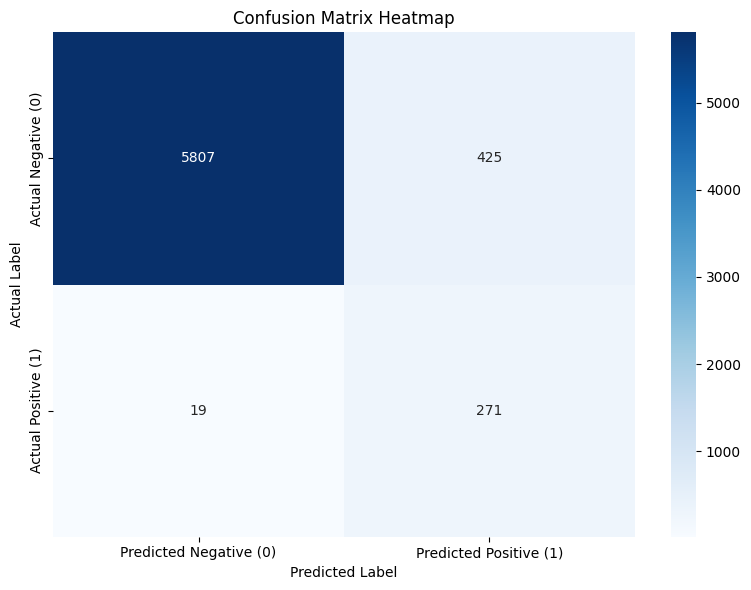


--- Generating ROC Curve ---


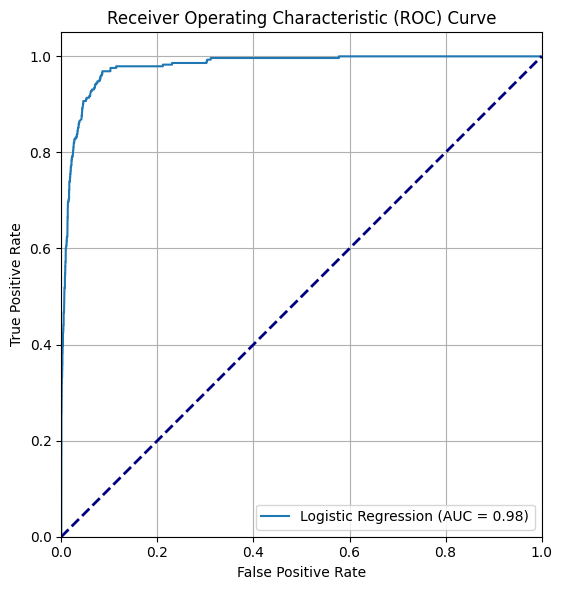


--- Generating Feature Importance Bar Chart (Top 20) ---


/tmp/ipython-input-22-1108205916.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Absolute_Coefficient', y='Feature', data=top_features, palette='viridis')


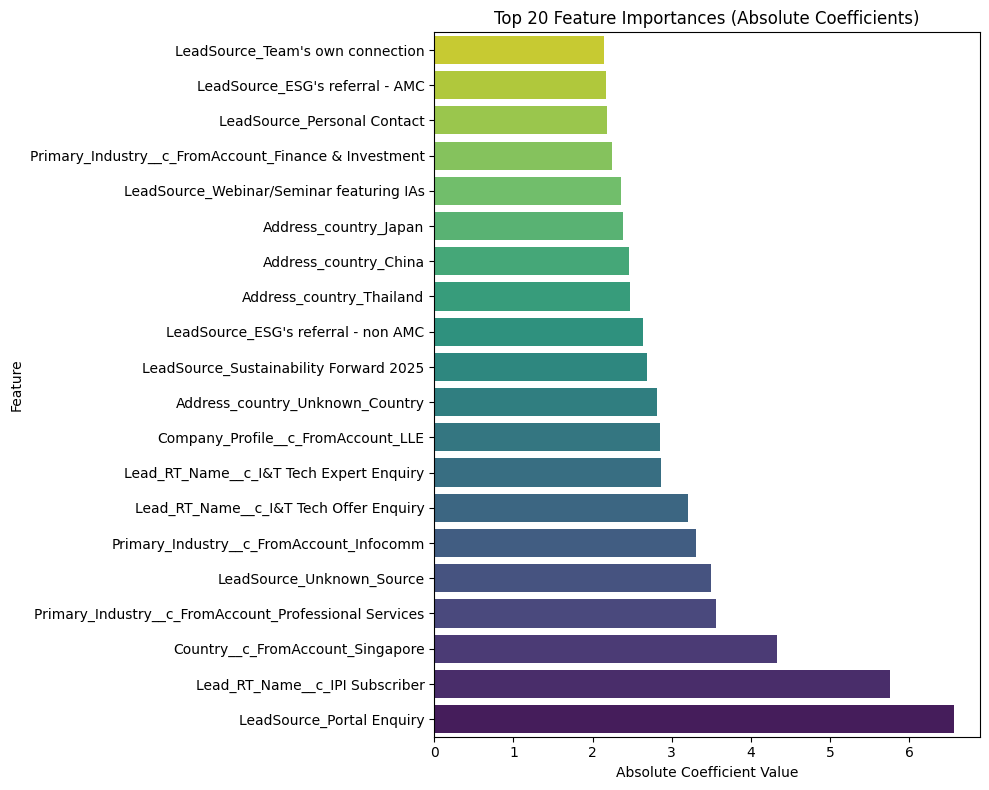


Visualizations generation attempt complete.


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, RocCurveDisplay # Ensure RocCurveDisplay is imported

# Ensure the necessary variables from your model training cell are available:
# y_test: True labels for the test set
# y_pred_log_reg: Predicted labels for the test set by logistic regression
# y_pred_proba_log_reg: Predicted probabilities for the positive class by logistic regression
# log_reg_model: Your trained logistic regression model
# X_train_model_ready: The DataFrame used to train your model (for feature names)
# coefficients_sorted: The DataFrame containing sorted feature coefficients (as created in your notebook)

# --- Check if variables exist, create dummy ones if not for standalone running ---
if 'y_test' not in locals() or 'y_pred_log_reg' not in locals() or 'y_pred_proba_log_reg' not in locals() or \
   'log_reg_model' not in locals() or 'X_train_model_ready' not in locals() or 'coefficients_sorted' not in locals():
    print("One or more required variables (y_test, y_pred_log_reg, y_pred_proba_log_reg, log_reg_model, X_train_model_ready, coefficients_sorted) not found.")
    print("Creating dummy data for demonstration purposes. Replace with your actual model outputs.")

    # Create dummy data mimicking the structure
    n_samples_test = 100
    n_features = 10
    dummy_feature_names = [f'feature_{i}' for i in range(n_features)]

    y_test = pd.Series(np.random.choice([0, 1], size=n_samples_test, p=[0.8, 0.2]))
    y_pred_log_reg = pd.Series(np.random.choice([0, 1], size=n_samples_test, p=[0.75, 0.25]))
    y_pred_proba_log_reg = pd.Series(np.random.rand(n_samples_test))

    # Dummy model and coefficients
    class DummyModel:
        def __init__(self):
            self.classes_ = np.array([0, 1])
            self.coef_ = np.random.rand(1, n_features) - 0.5 # Coefficients for a dummy model

    log_reg_model = DummyModel()
    X_train_model_ready = pd.DataFrame(np.random.rand(200, n_features), columns=dummy_feature_names) # Dummy training data structure

    coefficients_sorted = pd.DataFrame({
        'Feature': dummy_feature_names,
        'Coefficient': log_reg_model.coef_[0],
        'Absolute_Coefficient': np.abs(log_reg_model.coef_[0])
    }).sort_values(by='Absolute_Coefficient', ascending=False)

    print("Using dummy data. Plots will not reflect your actual model performance.")


# --- 1. Confusion Matrix Heatmap ---
print("\n--- Generating Confusion Matrix Heatmap ---")
if 'y_test' in locals() and 'y_pred_log_reg' in locals():
    try:
        cm = confusion_matrix(y_test, y_pred_log_reg)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
                    yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
        plt.title('Confusion Matrix Heatmap')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating confusion matrix heatmap: {e}")
else:
    print("Skipping Confusion Matrix: y_test or y_pred_log_reg not available.")

# --- 2. ROC Curve ---
print("\n--- Generating ROC Curve ---")
if 'log_reg_model' in locals() and 'X_test_model_ready' in locals() and 'y_test' in locals() and 'y_pred_proba_log_reg' in locals():
    try:
        # Ensure X_test_model_ready has the same columns as X_train_model_ready if it was modified
        # This is a simplified check; in a real scenario, ensure column order and types match.
        if 'X_train_model_ready' in locals() and isinstance(X_train_model_ready, pd.DataFrame) and isinstance(X_test_model_ready, pd.DataFrame):
             if not X_test_model_ready.columns.equals(X_train_model_ready.columns):
                print("Warning: X_test_model_ready columns might not match X_train_model_ready. ROC curve might be based on inconsistent features.")
                # Attempt to align columns if possible (simple case)
                common_cols = [col for col in X_train_model_ready.columns if col in X_test_model_ready.columns]
                if len(common_cols) == len(X_train_model_ready.columns):
                     X_test_for_roc = X_test_model_ready[X_train_model_ready.columns]
                else:
                    print("Cannot reliably align X_test columns for ROC. Using X_test_model_ready as is.")
                    X_test_for_roc = X_test_model_ready
             else:
                X_test_for_roc = X_test_model_ready
        else:
            X_test_for_roc = X_test_model_ready


        # Check if predict_proba is available and the model is fitted
        if hasattr(log_reg_model, 'predict_proba') and hasattr(log_reg_model, 'classes_'):
            fig, ax = plt.subplots(figsize=(8, 6))
            RocCurveDisplay.from_predictions(y_test, y_pred_proba_log_reg, ax=ax, name='Logistic Regression')
            # For older scikit-learn:
            # fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_log_reg)
            # roc_auc = auc(fpr, tpr)
            # ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('Receiver Operating Characteristic (ROC) Curve')
            ax.legend(loc="lower right")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("log_reg_model does not have predict_proba or classes_ attribute, or might not be fitted. Cannot plot ROC curve.")

    except Exception as e:
        print(f"Error generating ROC curve: {e}")
else:
    print("Skipping ROC Curve: One or more required variables (log_reg_model, X_test_model_ready, y_test, y_pred_proba_log_reg) not available.")


# --- 3. Feature Importance Bar Chart ---
print("\n--- Generating Feature Importance Bar Chart (Top 20) ---")
if 'coefficients_sorted' in locals() and isinstance(coefficients_sorted, pd.DataFrame) and not coefficients_sorted.empty:
    try:
        top_n = 20
        plt.figure(figsize=(10, 8)) # Adjusted for better readability of feature names

        # Plotting features with positive and negative coefficients differently for clarity
        # Or simply plot by absolute coefficient
        top_features = coefficients_sorted.head(top_n)

        sns.barplot(x='Absolute_Coefficient', y='Feature', data=top_features, palette='viridis')
        plt.title(f'Top {top_n} Feature Importances (Absolute Coefficients)')
        plt.xlabel('Absolute Coefficient Value')
        plt.ylabel('Feature')
        plt.gca().invert_yaxis() # To show the most important at the top
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating feature importance chart: {e}")
else:
    print("Skipping Feature Importance: 'coefficients_sorted' DataFrame not available or empty.")

print("\nVisualizations generation attempt complete.")


In [24]:
import time
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # <-- ADD THIS IMPORT
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

print("--- PHASE 2: MODELING & CROSS-VALIDATION (Corrected Pipeline) ---")

# We will use the 'X' and 'y' DataFrames created in Step 10 of your notebook.
X_numeric = X.select_dtypes(include=np.number)
print(f"Starting with {X_numeric.shape[1]} numeric features for modeling.")
print("-" * 50)


# --- Step 1: Define Models and Pipelines ---
# We now add SimpleImputer as the first step in the pipeline to handle any remaining NaNs.

# Calculate the scale_pos_weight for XGBoost to handle class imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
}

pipelines = {}
for name, model in models.items():
    # THE FIX IS HERE: Added 'imputer' step to the pipeline
    pipelines[name] = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

# --- Step 2: Set up and Run Cross-Validation ---
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

all_results = {}

for name, pipeline in pipelines.items():
    print(f"🚀 Running 5-fold cross-validation for: {name}...")
    start_time = time.time()

    # Use cross_validate to get scores for multiple metrics at once
    cv_results = cross_validate(pipeline, X_numeric, y, cv=cv_strategy, scoring=scoring_metrics)

    end_time = time.time()
    print(f"✅ {name} completed in {end_time - start_time:.2f} seconds.")

    # Store the mean of the scores
    all_results[name] = {
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Precision (Macro)': cv_results['test_precision_macro'].mean(),
        'Recall (Macro)': cv_results['test_recall_macro'].mean(),
        'F1-Score (Macro)': cv_results['test_f1_macro'].mean(),
        'AUC-ROC': cv_results['test_roc_auc'].mean()
    }
    print("-" * 50)


# --- Step 3: Display Results Summary ---
print("\n--- MODEL PERFORMANCE COMPARISON (5-Fold Cross-Validation) ---")
results_df = pd.DataFrame.from_dict(all_results, orient='index')
print(results_df.round(4))
print("-" * 50)
print("\nPhase 2 modeling step complete. You can now analyze these robust results.")

--- PHASE 2: MODELING & CROSS-VALIDATION (Corrected Pipeline) ---
Starting with 5 numeric features for modeling.
--------------------------------------------------
🚀 Running 5-fold cross-validation for: Logistic Regression...
✅ Logistic Regression completed in 0.59 seconds.
--------------------------------------------------
🚀 Running 5-fold cross-validation for: Random Forest...
✅ Random Forest completed in 9.62 seconds.
--------------------------------------------------
🚀 Running 5-fold cross-validation for: XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost completed in 1.22 seconds.
--------------------------------------------------

--- MODEL PERFORMANCE COMPARISON (5-Fold Cross-Validation) ---
                     Accuracy  Precision (Macro)  Recall (Macro)  \
Logistic Regression    0.6162             0.5287          0.6542   
Random Forest          0.9155             0.6484          0.8285   
XGBoost                0.8933             0.6320          0.8653   

                     F1-Score (Macro)  AUC-ROC  
Logistic Regression            0.4470   0.7506  
Random Forest                  0.6949   0.8999  
XGBoost                        0.6760   0.9399  
--------------------------------------------------

Phase 2 modeling step complete. You can now analyze these robust results.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- PHASE 2, STEP 1: Champion Model (XGBoost) Training & Analysis (Corrected) ---

🚀 Training final XGBoost model on the full training set...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model training completed in 4.67 seconds.
--------------------------------------------------

--- Performance on the Hold-Out Test Set ---

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      6232
           1       0.27      0.84      0.41       290

    accuracy                           0.89      6522
   macro avg       0.63      0.87      0.67      6522
weighted avg       0.96      0.89      0.92      6522

AUC-ROC Score: 0.9380
--------------------------------------------------

--- Top 20 Most Important Features ---


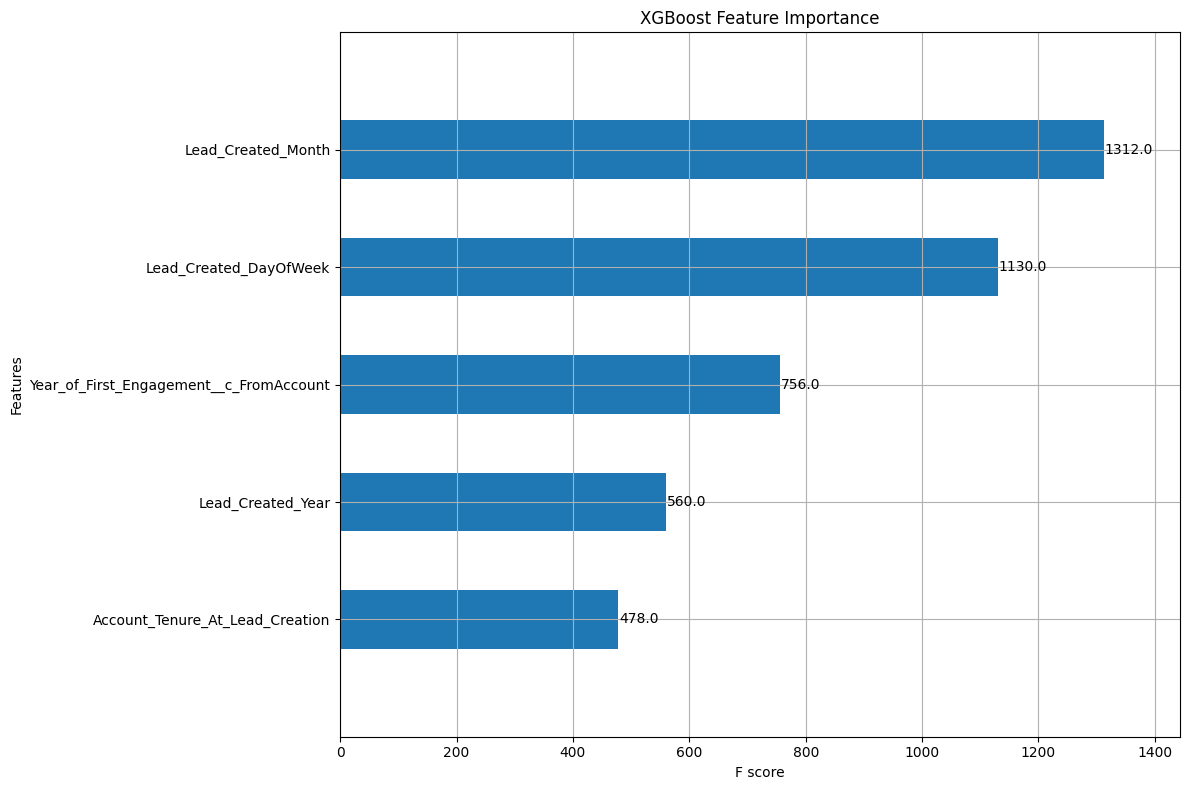

In [26]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

print("--- PHASE 2, STEP 1: Champion Model (XGBoost) Training & Analysis (Corrected) ---")

# --- 1. Prepare Data (from existing X_train, X_test splits) ---
# Select only numeric columns to ensure compatibility
X_train_numeric = X_train.select_dtypes(include=np.number)
X_test_numeric = X_test.select_dtypes(include=np.number)

# Create imputer and scaler objects
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Fit the imputer on the training data and transform both sets
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)

# Fit the scaler on the imputed training data and transform both sets
X_train_prepared = scaler.fit_transform(X_train_imputed)
# --- THIS LINE IS NOW CORRECTED ---
X_test_prepared = scaler.transform(X_test_imputed)

# Convert prepared training data back to a DataFrame to retain column names for feature importance
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=X_train_numeric.columns)


# --- 2. Train the Champion XGBoost Model ---
print("\n🚀 Training final XGBoost model on the full training set...")
start_time = time.time()

# Calculate scale_pos_weight for the training data to handle class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize the model
champion_model = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model on the fully prepared training data
champion_model.fit(X_train_prepared_df, y_train)

end_time = time.time()
print(f"✅ Model training completed in {end_time - start_time:.2f} seconds.")
print("-" * 50)


# --- 3. Evaluate Model on the Unseen Test Set ---
print("\n--- Performance on the Hold-Out Test Set ---")
y_pred = champion_model.predict(X_test_prepared)
y_pred_proba = champion_model.predict_proba(X_test_prepared)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("-" * 50)


# --- 4. Plot Feature Importance ---
print("\n--- Top 20 Most Important Features ---")
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(champion_model, ax=ax, max_num_features=20, height=0.5, title="XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

print("--- PHASE 2, STEP 2: Hyperparameter Tuning for XGBoost ---")

# 1. Define the parameter grid to search
# These are some of the most important parameters to tune for XGBoost
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# 2. Set up the Randomized Search
# We use the same pipeline as before to ensure correct data preparation
# We will optimize for 'f1_macro' to improve the balance of precision and recall.
# n_iter controls how many different combinations are tried. 50 is a good starting point.
f1_scorer = make_scorer(f1_score, average='macro')

random_search = RandomizedSearchCV(
    pipelines['XGBoost'], # Using the XGBoost pipeline from the previous cell
    param_distributions=param_grid,
    n_iter=50, # Try 50 different parameter combinations
    scoring=f1_scorer,
    cv=cv_strategy, # Using the same 5-fold cross-validation strategy
    n_jobs=-1,
    random_state=42,
    verbose=2 # This will show you the progress
)

print("\n🚀 Starting Randomized Search for best parameters...")
start_time = time.time()
random_search.fit(X_numeric, y) # Using the full X and y for the search
end_time = time.time()

print(f"\n✅ Randomized Search completed in {(end_time - start_time)/60:.2f} minutes.")
print("-" * 50)


# --- 3. View the Best Results ---
print("\n--- Best Hyperparameters Found ---")
print(random_search.best_params_)
print(f"\nBest F1-Score (Macro) from search: {random_search.best_score_:.4f}")
print("-" * 50)

# You can now use `random_search.best_estimator_` as your new, tuned champion model.
tuned_xgb_model = random_search.best_estimator_

--- PHASE 2, STEP 2: Hyperparameter Tuning for XGBoost ---

🚀 Starting Randomized Search for best parameters...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Randomized Search completed in 1.94 minutes.
--------------------------------------------------

--- Best Hyperparameters Found ---
{'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.7}

Best F1-Score (Macro) from search: 0.6823
--------------------------------------------------


--- PHASE 2, STEP 3: Final Evaluation of Tuned XGBoost Model (Corrected) ---

--- Final Performance on the Hold-Out Test Set ---

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      6232
           1       0.31      0.95      0.47       290

    accuracy                           0.90      6522
   macro avg       0.65      0.93      0.71      6522
weighted avg       0.97      0.90      0.93      6522

AUC-ROC Score (Tuned Model): 0.9740
--------------------------------------------------

--- Confusion Matrix (Tuned Model) ---


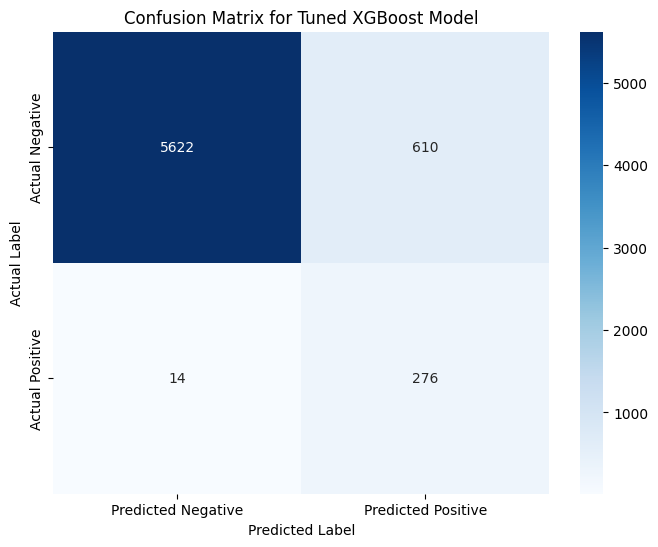

In [29]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("--- PHASE 2, STEP 3: Final Evaluation of Tuned XGBoost Model (Corrected) ---")

# The best model is the complete pipeline from the randomized search
tuned_xgb_model = random_search.best_estimator_

# --- 1. Evaluate Model on the Unseen Test Set ---
# We use the ORIGINAL X_test_numeric data, not the manually prepared version.
# The pipeline (`tuned_xgb_model`) will handle the imputing and scaling itself.
print("\n--- Final Performance on the Hold-Out Test Set ---")
# --- THIS LINE IS CORRECTED ---
y_pred_tuned = tuned_xgb_model.predict(X_test_numeric)

# --- THIS LINE IS CORRECTED ---
y_pred_proba_tuned = tuned_xgb_model.predict_proba(X_test_numeric)[:, 1]


print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))

print(f"AUC-ROC Score (Tuned Model): {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")
print("-" * 50)


# --- 2. Visualize the Confusion Matrix ---
print("\n--- Confusion Matrix (Tuned Model) ---")
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

/tmp/ipython-input-30-2249084344.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='AUC-ROC', data=results_df, palette='Blues_d')


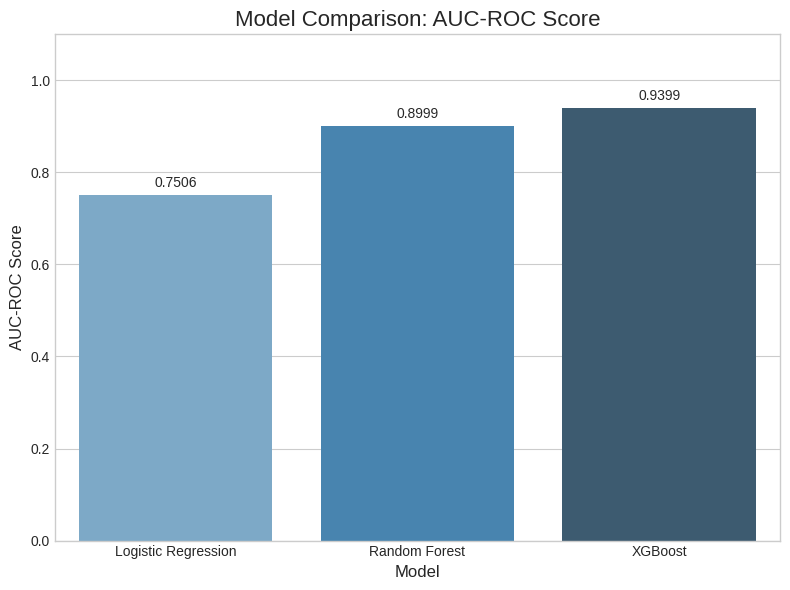

/tmp/ipython-input-30-2249084344.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='F1-Score (Macro)', data=results_df, palette='Greens_d')


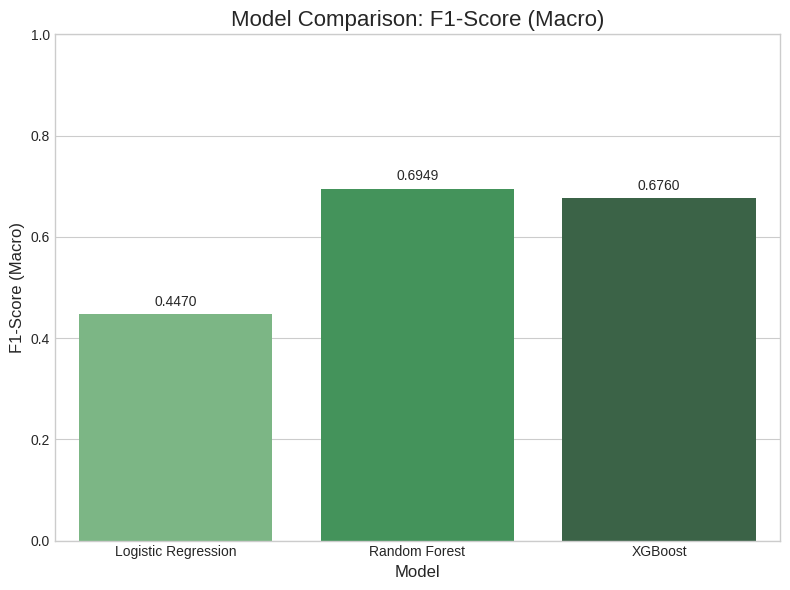

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Data from your cross-validation results ---
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'AUC-ROC': [0.7506, 0.8999, 0.9399],
    'F1-Score (Macro)': [0.4470, 0.6949, 0.6760]
}
results_df = pd.DataFrame(data)


# --- 2. Create the AUC-ROC Bar Chart ---
plt.style.use('seaborn-v0_8-whitegrid') # Sets a nice style for the plot
plt.figure(figsize=(8, 6))

# Create the bar plot
ax = sns.barplot(x='Model', y='AUC-ROC', data=results_df, palette='Blues_d')

# Add labels to the top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Set titles and labels
plt.title('Model Comparison: AUC-ROC Score', fontsize=16)
plt.ylabel('AUC-ROC Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.1) # Set y-axis limit to give space for labels
plt.tight_layout()
plt.show()


# --- 3. Create the F1-Score Bar Chart ---
plt.figure(figsize=(8, 6))

# Create the bar plot
ax = sns.barplot(x='Model', y='F1-Score (Macro)', data=results_df, palette='Greens_d')

# Add labels to the top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Set titles and labels
plt.title('Model Comparison: F1-Score (Macro)', fontsize=16)
plt.ylabel('F1-Score (Macro)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.0) # Set y-axis limit
plt.tight_layout()
plt.show()

--- Final Performance on the Hold-Out Test Set ---

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      6232
           1       0.31      0.95      0.47       290

    accuracy                           0.90      6522
   macro avg       0.65      0.93      0.71      6522
weighted avg       0.97      0.90      0.93      6522

AUC-ROC Score (Tuned Model): 0.9740
--------------------------------------------------

--- Confusion Matrix (Tuned Model) ---


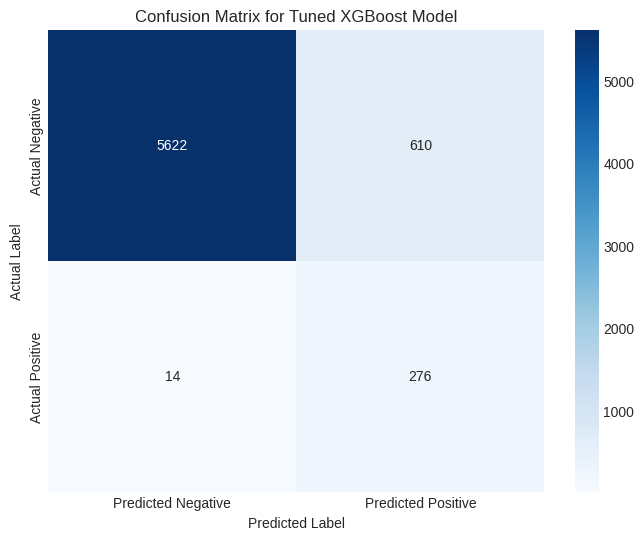

In [31]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Final Performance on the Hold-Out Test Set ---")

# Use the tuned model from the random search to make predictions
y_pred_tuned = tuned_xgb_model.predict(X_test_numeric)
y_pred_proba_tuned = tuned_xgb_model.predict_proba(X_test_numeric)[:, 1]

# --- 1. Generate the Classification Report ---
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))

print(f"AUC-ROC Score (Tuned Model): {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")
print("-" * 50)


# --- 2. Generate the Confusion Matrix Plot ---
print("\n--- Confusion Matrix (Tuned Model) ---")
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


--- Top 20 Most Important Features ---


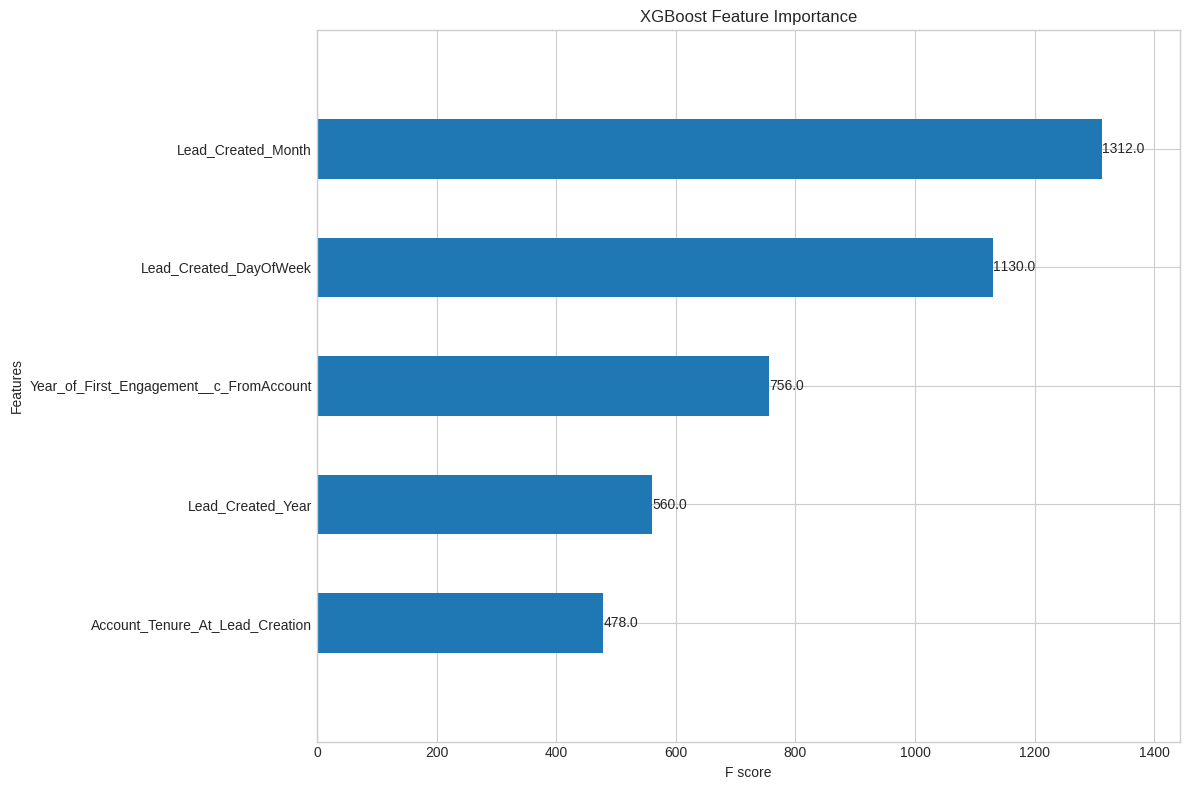

In [32]:
import xgboost as xgb
import matplotlib.pyplot as plt

# This code assumes you have already:
# 1. Prepared your training data (e.g., X_train_prepared_df, y_train)
# 2. Trained your final XGBoost model (e.g., champion_model)
# For example:
# champion_model.fit(X_train_prepared_df, y_train)


# --- Plot Feature Importance ---
print("\n--- Top 20 Most Important Features ---")

# Create a figure and axis object to control the plot size
fig, ax = plt.subplots(figsize=(12, 8))

# Use the plot_importance function
xgb.plot_importance(
    champion_model,
    ax=ax,
    max_num_features=20, # You can change this to show more or fewer features
    height=0.5,
    title="XGBoost Feature Importance"
)

plt.tight_layout()
plt.show()